# Dataset introduction

To build the speed limit detection system for self-driving cars, I start with model training on the German Traffic Sign Detection Benchmark (GTSDB) dataset which is a widely used collection of images containing various traffic signs.

The GTSDB dataset is a single-image detection assessment for researchers with interest in the field of computer vision, pattern recognition and image-based driver assistance. It is introduced on the IEEE International Joint Conference on Neural Networks 2013.[[1]](https://benchmark.ini.rub.de/gtsdb_news.html)

![Image Description](https://storage.googleapis.com/kaggle-datasets-images/985376/1664166/0a9ae27e9b68bfac1de08f99caae3657/dataset-cover.png?t=2020-11-20-12-13-24)

 It features …

- a single-image detection problem
- 900 images (divided into 600 training images and 300 evaluation images)
- the division into three categories that suit the properties of various detection approaches with different properties
- an online evaluation system with immediate analysis and ranking of the submitted results

![Three categories](https://html.scirp.org/file/5-3500422x16.png)

Although the dataset contains 43 categories for various traffic signs, the state-of-the-art model [[2]](https://www.sciencedirect.com/science/article/abs/pii/S092523121830924X) on this dataset only evaluates the object detection model's performance on three major group of categories: mandatory, prohibitory, danger as demonstrated above. For example, the speed limit is considered as prohibitory traffic sign. The SOTA model can detect these traffic signs and idenfity their group of categories but cannot recognize the speed limit as shown below.

![detection exmaple from SOTA model](https://github.com/aarcosg/traffic-sign-detection/raw/master/detection_example.png?raw=True)

# Data preparation

## download data from GTSDB website

In [38]:
! wget https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip

--2023-11-30 20:46:10--  https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1661866983 (1.5G) [application/zip]
Saving to: ‘FullIJCNN2013.zip’

FullIJCNN2013.zip   100%[===================>]   1.55G  3.96MB/s    in 7m 2s   

2023-11-30 20:53:13 (3.75 MB/s) - ‘FullIJCNN2013.zip’ saved [1661866983/1661866983]



In [ ]:
! unzip FullIJCNN2013.zip

# Transform GTSDB Dataset annotations to COCO Format

To use Detectron2 to train the object detection model, the dataset should be in COCO format. Given that GTSDB dataset is not in a standard format, I will start the data preparation by data transformation to COCO format (inspired from [here](http://https://gist.github.com/zhaoweizhong/053ce08beb9047b710b3616f75130c31))

## convert images from ppm to jpg

In [47]:
import os
from PIL import Image

def convert_ppm_to_jpg(source_dir, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    for filename in os.listdir(source_dir):
        if filename.endswith('.ppm'):
            img = Image.open(os.path.join(source_dir, filename))
            jpg_filename = os.path.splitext(filename)[0] + '.jpg'
            img.save(os.path.join(dest_dir, jpg_filename), 'JPEG')
convert_ppm_to_jpg('FullIJCNN2013', 'img_jpg')

## convert annotations to COCO format

we extract categories information from dataset description file and create the following mapping dict:

In [15]:
label_dict = {
    0: "20km/h",
    1: "30km/h",
    2: "50km/h",
    3: "60km/h",
    4: "70km/h",
    5: "80km/h",
    6: "End of 80km/h",
    7: "100km/h",
    8: "120km/h",
    9: "No overtaking",
    10: "No overtaking (trucks)",
    11: "Priority intersection",
    12: "Priority road",
    13: "Give way",
    14: "Stop",
    15: "No traffic",
    16: "No trucks",
    17: "No entry",
    18: "Danger",
    19: "Bend left",
    20: "Bend right",
    21: "Bend",
    22: "Uneven road",
    23: "Slippery road",
    24: "Road narrows",
    25: "Construction",
    26: "Traffic signal",
    27: "Pedestrian crossing",
    28: "School crossing",
    29: "Cycles crossing",
    30: "Snow",
    31: "Animals",
    32: "End of restriction",
    33: "Go right",
    34: "Go left",
    35: "Go straight",
    36: "Go right or straight",
    37: "Go left or straight",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout",
    41: "End of overtaking restriction",
    42: "End of overtaking restriction (trucks)"
}

In [16]:
import json
import argparse
import copy
import tqdm
import glob
import cv2
from PIL import Image

def load_txt(file_name):
    file = open(file_name, 'r')
    data = []
    for line in file.readlines():
        data.append(line.replace('\n', ''))
    return data

In [17]:
file_name = "FullIJCNN2013/gt.txt"
data = load_txt(file_name)
data[:5]

['00000.ppm;774;411;815;446;11',
 '00001.ppm;983;388;1024;432;40',
 '00001.ppm;386;494;442;552;38',
 '00001.ppm;973;335;1031;390;13',
 '00002.ppm;892;476;1006;592;39']

In [18]:
print(f"gt.txt contains {len(data)} annotations.")
print(f"the dataset contains {len(glob.glob('FullIJCNN2013/*.ppm'))} images.")

gt.txt contains 1213 annotations.
the dataset contains 900 images.


In [19]:
img_id_in_annotations = set([int(annotation.split(';')[0][:5]) for annotation in data])
print(f"there are {len(img_id_in_annotations)} images in the annotations.")

there are 741 images in the annotations.


we notice that there are 159 images that have no annotations. Let's investigate why by visualizing few of them. 

In [59]:
count = 0
no_annotation_img_ids = []
for id in range(0, 900):
    if id not in img_id_in_annotations:
        no_annotation_img_ids.append(id)

def show_img(img_id):
    img = cv2.imread(f"FullIJCNN2013/{img_id:05d}.ppm")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

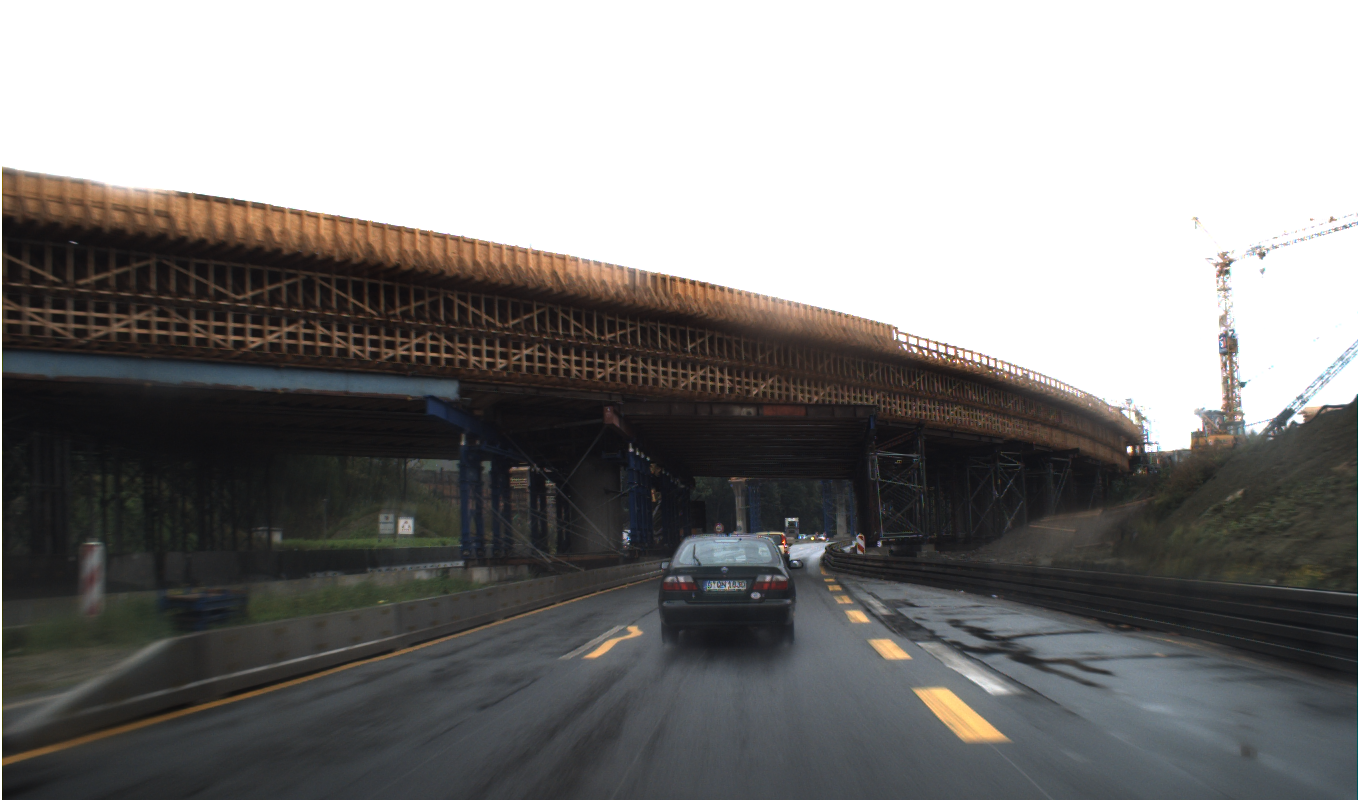

In [60]:
Image.fromarray(show_img(no_annotation_img_ids[0]))

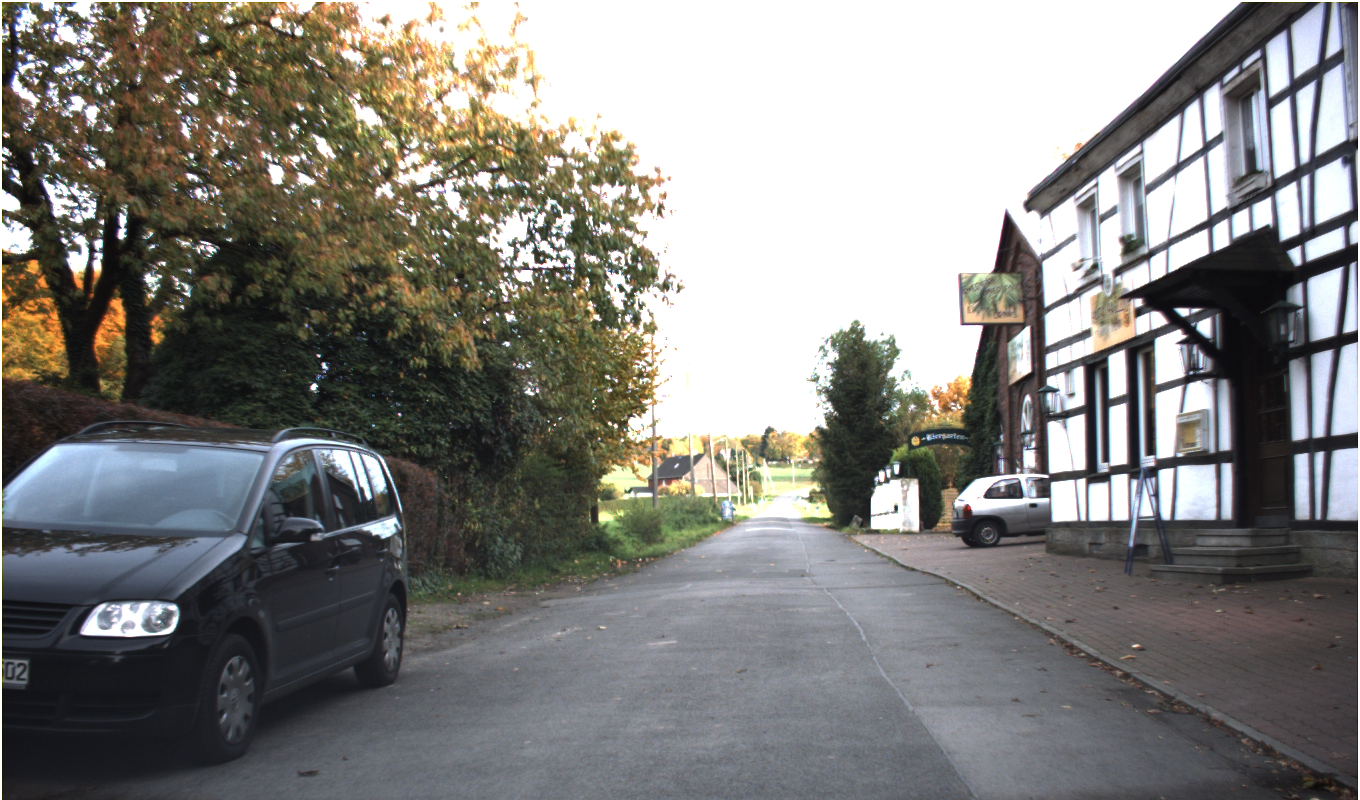

In [61]:
Image.fromarray(show_img(no_annotation_img_ids[1]))

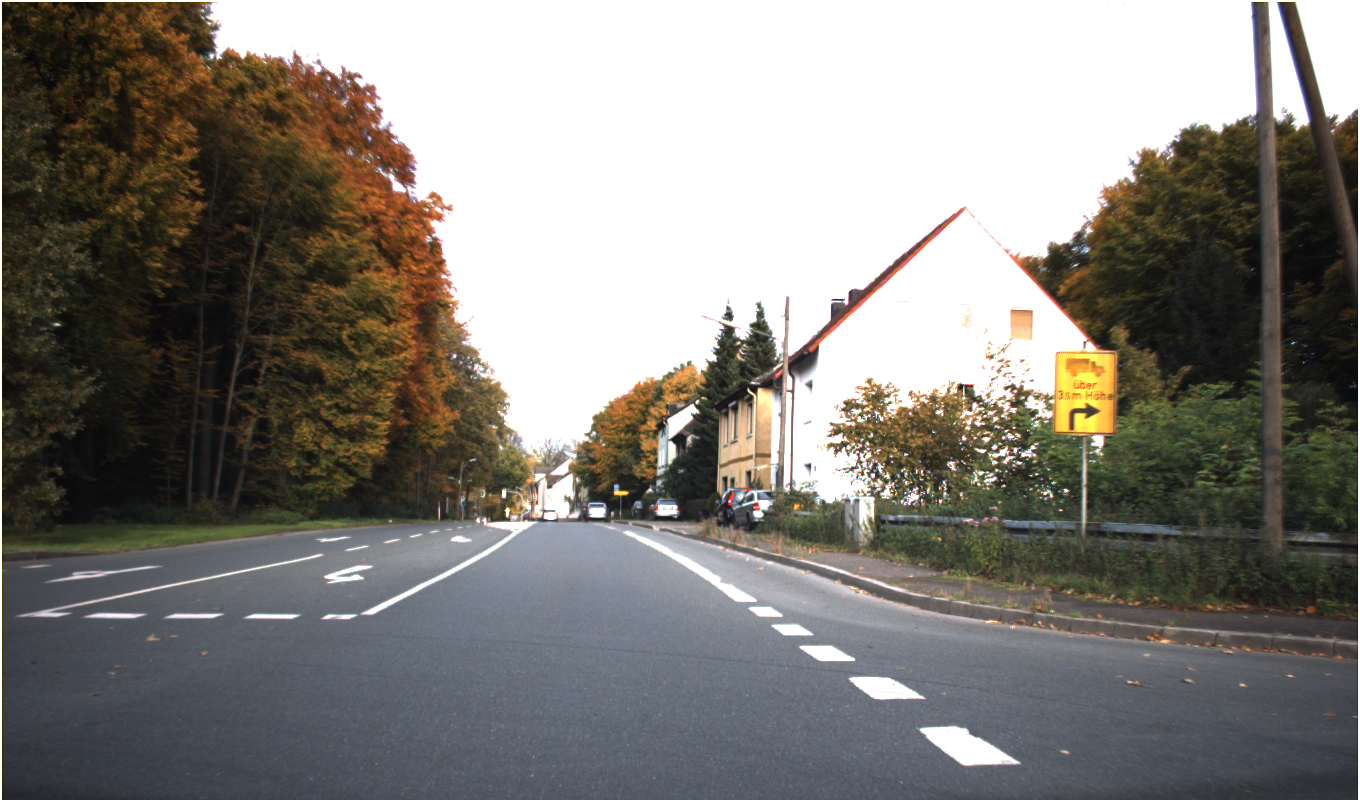

In [62]:
Image.fromarray(show_img(no_annotation_img_ids[2]))

It turns out that the absence of annotations comes from the absence of traffic signs on these images.

In [20]:
def parse(data):
    # File Format
    result_train = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    for i in range(0, 43):
        result_train['categories'].append({
            "id": i,
            "name": label_dict[i],
        })

    result_test = copy.deepcopy(result_train)

    # Images and Annotations
    count = 900
    count_train = int(count * 0.7)
    anno_id = 0
    for annotation in tqdm.tqdm(data):
        img_id = int(annotation.split(';')[0][:5])
        img_name = annotation.split(';')[0][:5] + '.jpg'
        xmin = int(annotation.split(';')[1])
        ymin = int(annotation.split(';')[2])
        xmax = int(annotation.split(';')[3])
        ymax = int(annotation.split(';')[4])
        class_id = int(annotation.split(';')[5])
        if img_id < count_train:
            if not bool([True for img in result_train['images'] if img['id'] == img_id]):
                result_train['images'].append({
                    "file_name": img_name,
                    "height": 800,
                    "width": 1360,
                    "id": img_id
                })
            result_train['annotations'].append({
                "area": (xmax - xmin) * (ymax - ymin),
                "iscrowd": 0,
                "image_id": img_id,
                "bbox": [
                    xmin,
                    ymin,
                    xmax - xmin,
                    ymax - ymin
                ],
                "category_id": class_id,
                "id": anno_id
            })
        else:
            if not bool([True for img in result_test['images'] if img['id'] == img_id]):
                result_test['images'].append({
                    "file_name": img_name,
                    "height": 800,
                    "width": 1360,
                    "id": img_id
                })
            result_test['annotations'].append({
                "area": (xmax - xmin) * (ymax - ymin),
                "iscrowd": 0,
                "image_id": img_id,
                "bbox": [
                    xmin,
                    ymin,
                    xmax - xmin,
                    ymax - ymin
                ],
                "category_id": class_id,
                "id": anno_id
            })
        anno_id = anno_id + 1
    
    print('Train Images: ' + str(len(result_train['images'])))
    print('Test Images: ' + str(len(result_test['images'])))
    print('Train Annotations: ' + str(len(result_train['annotations'])))
    print('Test Annotations: ' + str(len(result_test['annotations'])))

    with open('train.json', "w") as f:
        json.dump(result_train, f)

    with open('test.json', "w") as f:
        json.dump(result_test, f)

Each row contains the file name, bounding box coordinates and label index.

In [21]:
parse(data)

100%|██████████| 1213/1213 [00:00<00:00, 59173.64it/s]

Train Images: 530
Test Images: 211
Train Annotations: 889
Test Annotations: 324


In [22]:
# have a look at json file
import json
with open("train.json", "rb") as f:
    train_data = json.load(f)

In [23]:
train_data.keys()

dict_keys(['images', 'annotations', 'categories'])

In [24]:
train_data["annotations"][0]

{'area': 1435,
 'iscrowd': 0,
 'image_id': 0,
 'bbox': [774, 411, 41, 35],
 'category_id': 11,
 'id': 0}

In [25]:
train_data["images"][0]

{'file_name': '00000.jpg', 'height': 800, 'width': 1360, 'id': 0}

# Dataset visualization using fiftyone

**Fiftyone** is an open-source tool for building high-quality datasets and computer vision models. By using FiftyOne, we can get hands-on with our data, including visualizing complex labels, evaluating the models, exploring scenarios of interest, identifying failure modes, finding annotation mistakes, etc.

In [ ]:
!pip install fiftyone

In [27]:
import json 
with open('train.json') as f:
    data = json.load(f)

In [28]:
data.keys()

dict_keys(['images', 'annotations', 'categories'])

In [29]:
data["images"][0]

{'file_name': '00000.jpg', 'height': 800, 'width': 1360, 'id': 0}

In [12]:
data2["images"][0]

{'file_name': '0000f77c-6257be58.jpg', 'height': 720, 'width': 1280, 'id': 1}

In [5]:
data2.keys()

dict_keys(['categories', 'type', 'images', 'annotations'])

In [7]:
data2["type"]

'instances'

In [30]:
import fiftyone as fo
# The directory containing the source images
data_path = "/Users/hugo/SpeedLimitDetection/img_jpg"

# The path to the BDD100k labels JSON file
labels_path = "/Users/hugo/SpeedLimitDetection/train.json"
fo.delete_dataset("gtsdb-train")
# Import the dataset
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path,
    name = "gtsdb-train",
)
dataset.persistent = True


 100% |█████████████████| 530/530 [392.6ms elapsed, 0s remaining, 1.3K samples/s]      



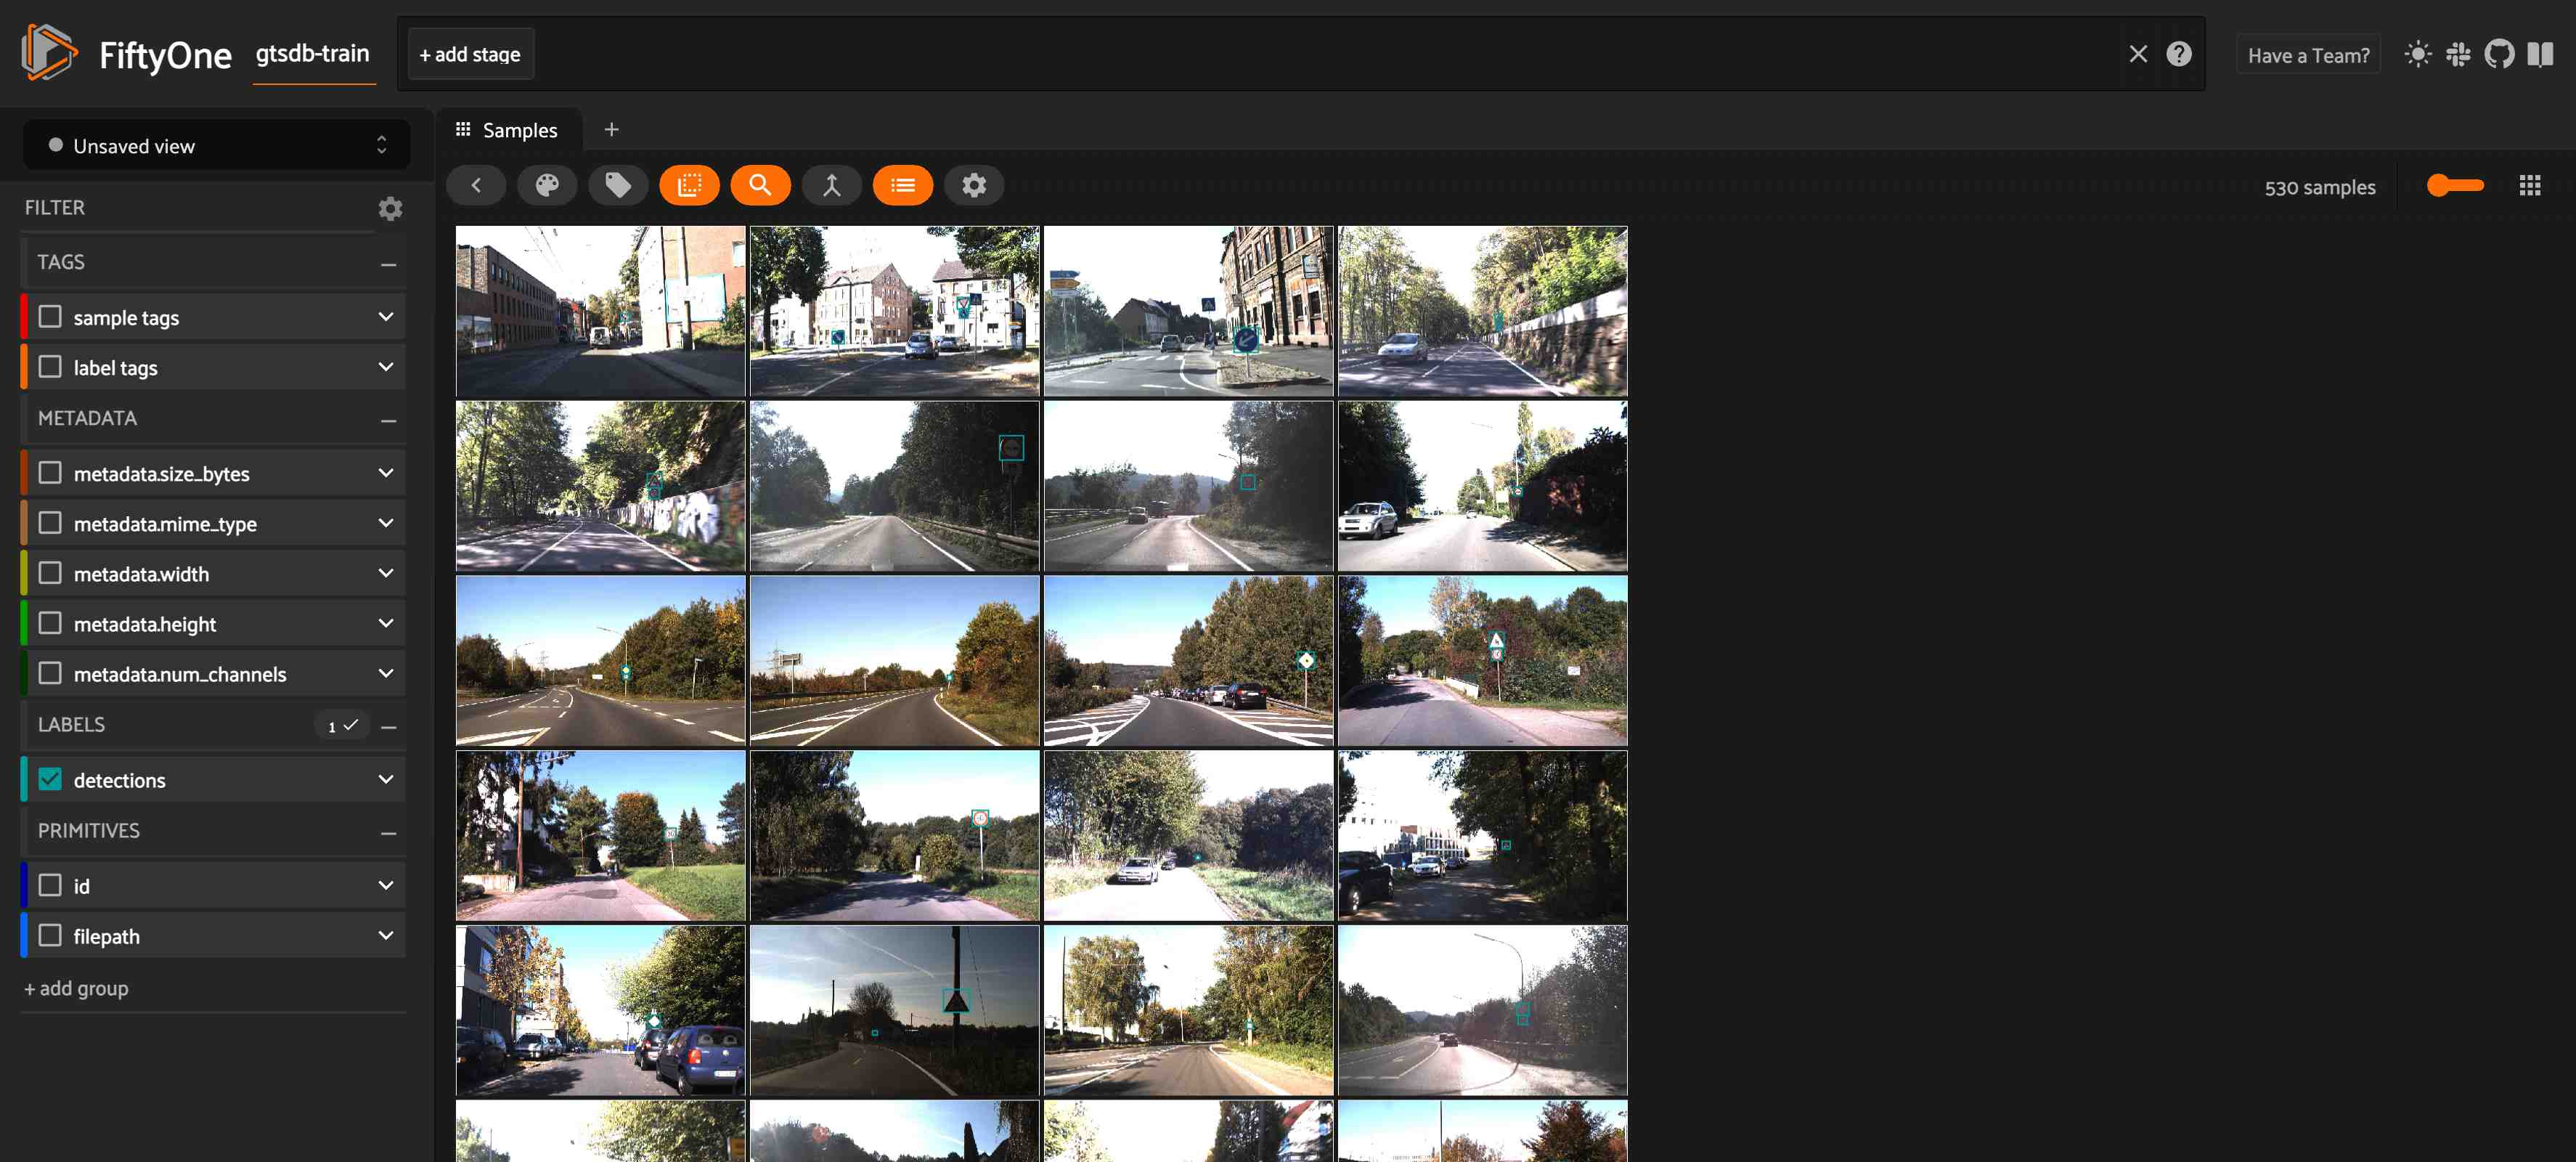

In [1]:
import fiftyone as fo 
dataset = fo.load_dataset("gtsdb-train")
session = fo.launch_app(dataset, port=51018)
session.freeze()

/var/folders/m5/01zk54qj41sd7l141z41l6dw0000gn/T/ipykernel_37673/3731184750.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_series.index, y=counts_series.values, palette=palette)


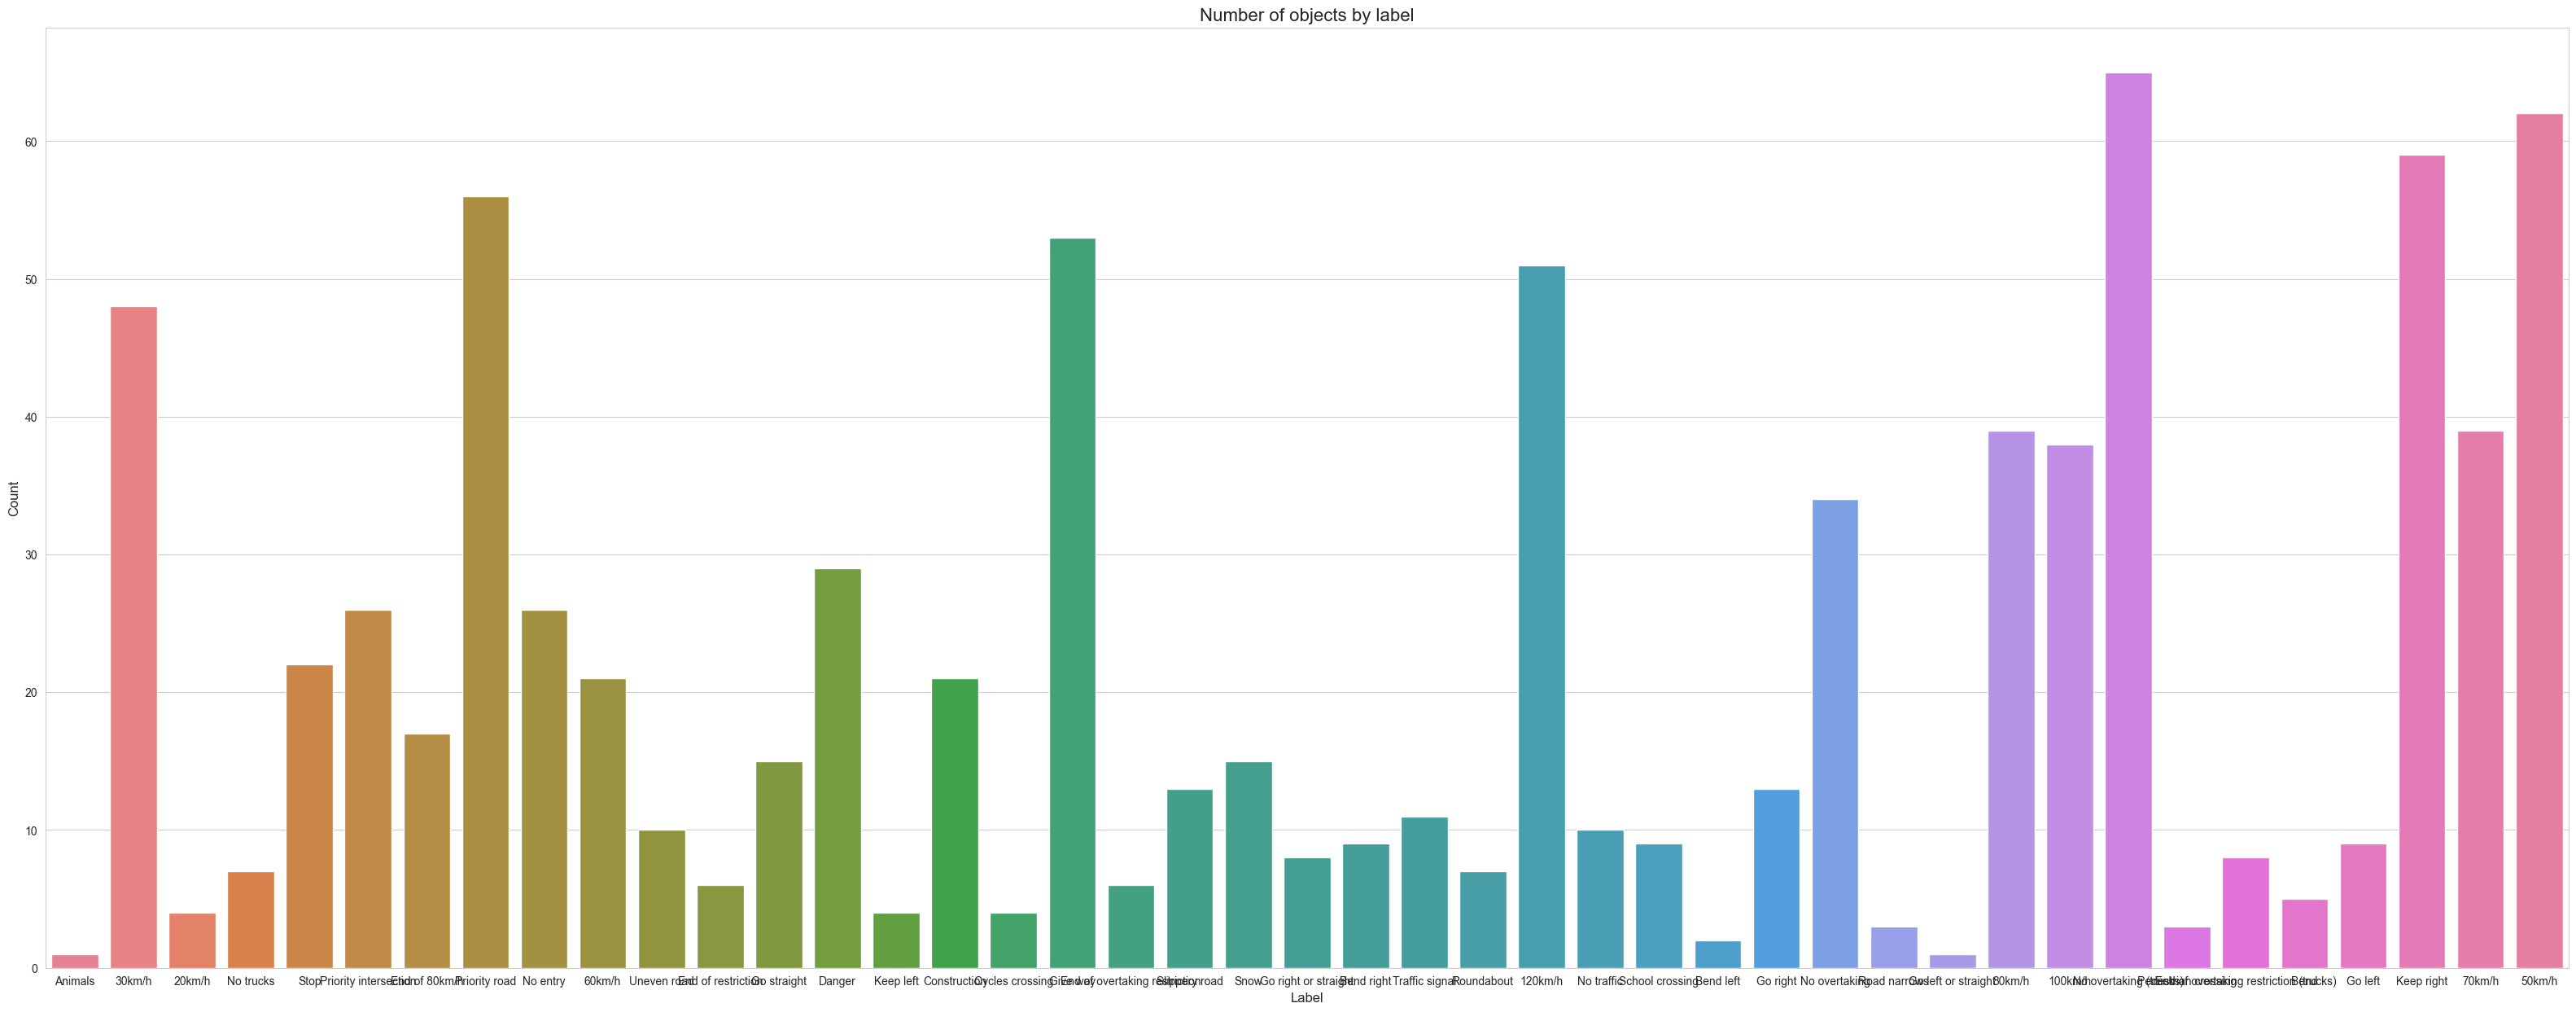

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
counts_label = dataset.count_values("detections.detections.label")
counts_series = pd.Series(counts_label)

# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("husl", len(counts_label ))
plt.figure(figsize=(40, 15)) 
# Create the plot
sns.barplot(x=counts_series.index, y=counts_series.values, palette=palette)

# Set the labels and title
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Number of objects by label', fontsize=16)

plt.show()

Since we focus on speed limit detection, we select only the traffic signs related to speed limit as training data. 

In [11]:
from fiftyone import ViewField as F
speed_label = ['20km/h',  '30km/h',  '50km/h',  '60km/h',  '70km/h',  '80km/h',  '100km/h',  '120km/h']
dataset_speed = dataset.filter_labels("detections", F("label").is_in(speed_label))

In [13]:
session.view = dataset_speed

/var/folders/m5/01zk54qj41sd7l141z41l6dw0000gn/T/ipykernel_37673/616361011.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_series.index, y=counts_series.values, palette=palette)


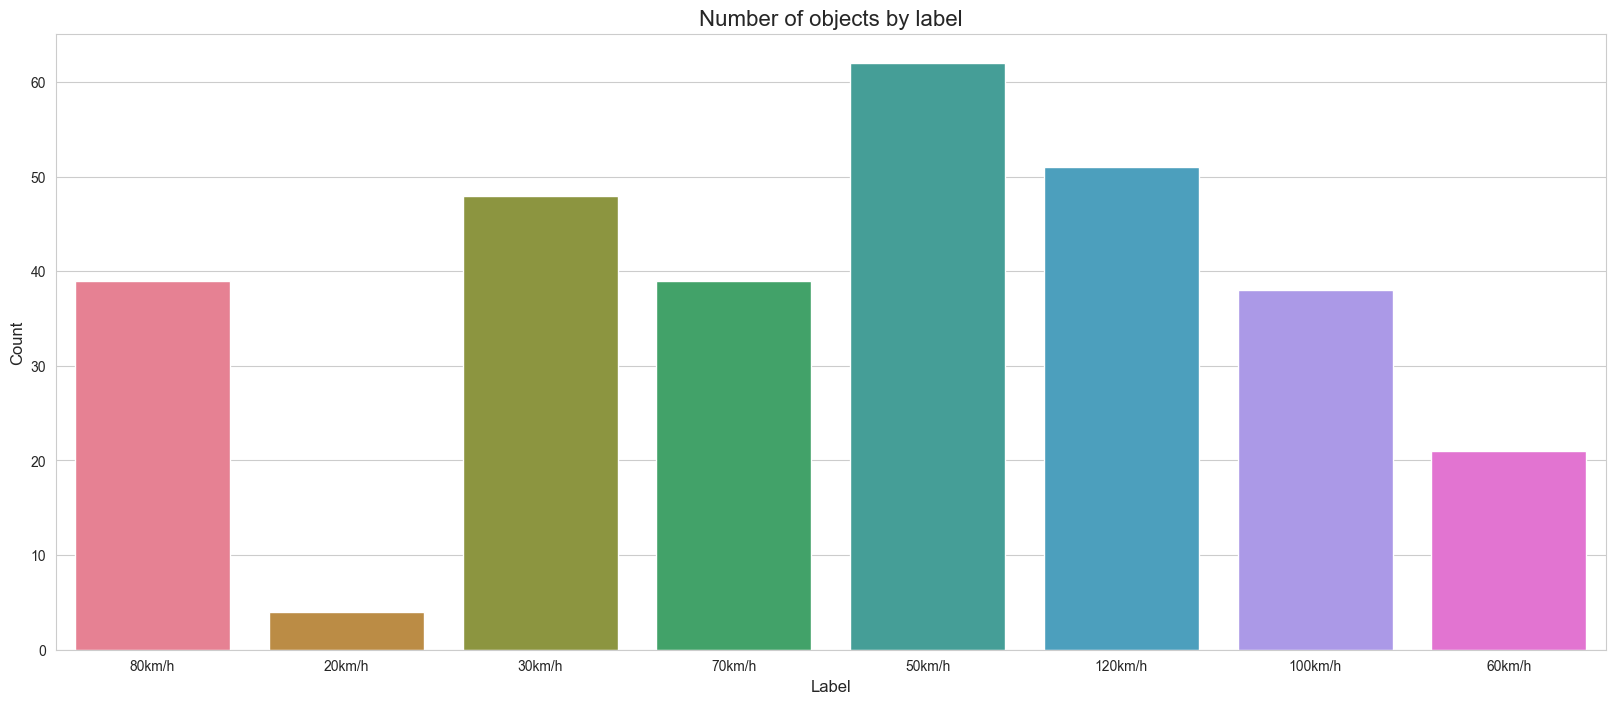

In [15]:
counts_label = dataset_speed.count_values("detections.detections.label")
counts_series = pd.Series(counts_label)

# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("husl", len(counts_label ))
plt.figure(figsize=(20, 8)) 
# Create the plot
sns.barplot(x=counts_series.index, y=counts_series.values, palette=palette)

# Set the labels and title
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Number of objects by label', fontsize=16)

plt.show()

**Remark**

In GTSDB, the number of instances for each category related to speed limit is very low, which is far from sufficient for training a large model for object detection, such as Faster-RCNN. 
We should investigate other related datasets to collect more speed limit signs data.